In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import zipfile
zip_ref = zipfile.ZipFile("/content/drive/MyDrive/kaggle/nih-chest-xrays-tfrecords.zip", 'r')
zip_ref.extractall("/content/nih-chest-xrays-tfrecords")
zip_ref.close()

In [4]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os

#mainpath = '../input/nih-chest-xrays-tfrecords/'
datadir ='/content/nih-chest-xrays-tfrecords/data'
csvpath = '/content/nih-chest-xrays-tfrecords/preprocessed_data.csv'

print(f'Image Data : {datadir}')
print(f'CSV file : {csvpath}')
# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

Image Data : /content/nih-chest-xrays-tfrecords/data
CSV file : /content/nih-chest-xrays-tfrecords/preprocessed_data.csv


##  **This notebook is using IG for Explainable. And Basic Model is Inception v3** 

### **Import TensorFlow**

In [5]:
import tensorflow as tf
print(f'TensorFlow Version : {tf.__version__}')

TensorFlow Version : 2.7.0


### This feature_map is followed by Orginal Dataset Guide(https://www.kaggle.com/nickuzmenkov/nih-chest-xrays-tfrecords) 

In [6]:
feature_map = {
    'image': tf.io.FixedLenFeature([], tf.string),
    'image_id': tf.io.FixedLenFeature([], tf.string),
    'No Finding': tf.io.FixedLenFeature([], tf.int64),
    'Atelectasis': tf.io.FixedLenFeature([], tf.int64),
    'Consolidation': tf.io.FixedLenFeature([], tf.int64),
    'Infiltration': tf.io.FixedLenFeature([], tf.int64),
    'Pneumothorax': tf.io.FixedLenFeature([], tf.int64),
    'Edema': tf.io.FixedLenFeature([], tf.int64),
    'Emphysema': tf.io.FixedLenFeature([], tf.int64),
    'Fibrosis': tf.io.FixedLenFeature([], tf.int64),
    'Effusion': tf.io.FixedLenFeature([], tf.int64),
    'Pneumonia': tf.io.FixedLenFeature([], tf.int64),
    'Pleural_Thickening': tf.io.FixedLenFeature([], tf.int64),
    'Cardiomegaly': tf.io.FixedLenFeature([], tf.int64),
    'Nodule': tf.io.FixedLenFeature([], tf.int64),
    'Mass': tf.io.FixedLenFeature([], tf.int64),
    'Hernia': tf.io.FixedLenFeature([], tf.int64)
}

### Decode TFR datafiles and decode image fromg deocded data

In [7]:
def tfr_decoder(path, shuffle=True):
    def image_decoder(data):
        example = tf.io.parse_single_example(data, feature_map) 
        image = example['image']
        image = tf.io.decode_image(image, channels=3)
        image = tf.image.convert_image_dtype(image, tf.float32)
        image = tf.image.resize_with_pad(image, 150, 150)
        image.set_shape([150,150,3])
        image = image/255.
        
        print([label for label in sorted(list(example.keys())) if label!='image' and label!='image_id'])
        labels = [tf.cast(example[x], tf.float32) for x in sorted(list(example.keys())) if x!='image_id' and x!='image']
        
        return image, labels
    
    data_list = [os.path.join(datadir,x) for x in os.listdir(path)]
    split = int(len(data_list)*0.8)
    train_data, val_data = data_list[:split], data_list[split:]
    
    trainds = tf.data.TFRecordDataset(train_data)
    trainds = trainds.map(image_decoder, num_parallel_calls=tf.data.experimental.AUTOTUNE)
    
    valds = tf.data.TFRecordDataset(val_data)
    valds = valds.map(image_decoder, num_parallel_calls=tf.data.experimental.AUTOTUNE)

    if shuffle:
        trainds = trainds.shuffle(1024)
        
    trainds = trainds.batch(128).prefetch(tf.data.experimental.AUTOTUNE)
    valds = valds.batch(128).prefetch(tf.data.experimental.AUTOTUNE)
    return trainds, valds

### **Check Label's order and shape of data**

In [8]:
trainds, valds = tfr_decoder(datadir)
print(trainds)

['Atelectasis', 'Cardiomegaly', 'Consolidation', 'Edema', 'Effusion', 'Emphysema', 'Fibrosis', 'Hernia', 'Infiltration', 'Mass', 'No Finding', 'Nodule', 'Pleural_Thickening', 'Pneumonia', 'Pneumothorax']
['Atelectasis', 'Cardiomegaly', 'Consolidation', 'Edema', 'Effusion', 'Emphysema', 'Fibrosis', 'Hernia', 'Infiltration', 'Mass', 'No Finding', 'Nodule', 'Pleural_Thickening', 'Pneumonia', 'Pneumothorax']
<PrefetchDataset shapes: ((None, 150, 150, 3), (None, 15)), types: (tf.float32, tf.float32)>


### Load Model from Keras and set pooling='avg' for setting output shape to 2D

In [9]:
effic = tf.keras.applications.EfficientNetB2(
    include_top=False, weights=None,input_shape=(150,150,3), pooling='avg')

incep = tf.keras.applications.InceptionV3(
    include_top=False, weights=None, input_shape=(150,150,3), pooling='avg')

model = tf.keras.Sequential([
            incep,
            tf.keras.layers.Dense(512, activation='relu'),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.Dense(128, activation='relu'),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.Dense(32, activation='relu'),
            tf.keras.layers.Dense(15, activation='sigmoid'),
])

model.compile(loss='binary_crossentropy',
             optimizer='Adam',
             metrics=[tf.keras.metrics.AUC(multi_label=True),'binary_accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inception_v3 (Functional)   (None, 2048)              21802784  
                                                                 
 dense (Dense)               (None, 512)               1049088   
                                                                 
 batch_normalization_94 (Bat  (None, 512)              2048      
 chNormalization)                                                
                                                                 
 dense_1 (Dense)             (None, 128)               65664     
                                                                 
 batch_normalization_95 (Bat  (None, 128)              512       
 chNormalization)                                                
                                                                 
 dense_2 (Dense)             (None, 32)                4

In [10]:
model.fit(trainds, epochs=3)
model.evaluate(valds)

Epoch 1/3
699/699 [==============================] - 689s 912ms/step - loss: 0.2232 - auc: 0.5982 - binary_accuracy: 0.9207
Epoch 2/3
699/699 [==============================] - 632s 896ms/step - loss: 0.2051 - auc: 0.6552 - binary_accuracy: 0.9283
Epoch 3/3
178/178 [==============================] - 120s 659ms/step - loss: 0.2055 - auc: 0.6571 - binary_accuracy: 0.9293


[0.20552630722522736, 0.6571130752563477, 0.9293293952941895]

In [11]:
forecast = model.predict(valds)

### Check First Data from Valds and get image data from that

In [12]:
label_list = ['Atelectasis', 'Cardiomegaly', 'Consolidation', 'Edema', 'Effusion', 'Emphysema', 'Fibrosis', 
              'Hernia', 'Infiltration', 'Mass', 'No Finding', 'Nodule', 'Pleural_Thickening', 'Pneumonia', 
              'Pneumothorax']
columns = {}
for label in label_list:
    columns[label] = []
    
for element in valds.as_numpy_iterator():
    for label in element[1]:
        for n, data in enumerate(label):
            columns[label_list[n]].append(data)
    
valdf = pd.DataFrame(columns)
valdf

,Atelectasis,Cardiomegaly,Consolidation,Edema,Effusion,Emphysema,Fibrosis,Hernia,Infiltration,Mass,No Finding,Nodule,Pleural_Thickening,Pneumonia,Pneumothorax
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22770,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
22771,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
22772,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
22773,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### **Let's check using Atelectasis Example**

In [13]:
Example = list(valdf.loc[valdf['Atelectasis'] == 1].head(10).index)

#### **Model is not good for predict :(**

In [14]:
val_image_data = []
for element in valds.as_numpy_iterator():
    for img in element[0]:
        img = img*255.0
        val_image_data.append(img)

### From here, We are going to use IG. For more information about using IG, Please check official guideline(https://www.tensorflow.org/tutorials/interpretability/integrated_gradients)

- target_class_idx is Number of label. for example, if you want check which pixels point Atelectasis Area, just set target_class_idx to 0. 

In [15]:
def interpolate_images(baseline,image,alphas):
    alphas_x = alphas[:, tf.newaxis, tf.newaxis, tf.newaxis]
    baseline_x = tf.expand_dims(baseline, axis=0)
    input_x = tf.expand_dims(image, axis=0)
    delta = input_x - baseline_x
    images = baseline_x +  alphas_x * delta
    return images

In [16]:
def compute_gradients(images, target_class_idx):
    with tf.GradientTape() as tape:
        tape.watch(images)
        logits = model(images)
        probs = tf.nn.softmax(logits, axis=-1)[:,target_class_idx]
        return tape.gradient(probs, images)

In [17]:
def integral_approximation(gradients):
    # riemann_trapezoidal
    grads = (gradients[:-1] + gradients[1:]) / tf.constant(2.0)
    integrated_gradients = tf.math.reduce_mean(grads, axis=0)
    return integrated_gradients

In [18]:
@tf.function
def integrated_gradients(baseline,image,target_class_idx, m_steps=150, batch_size=64):
    # 1. Generate alphas
    alphas = tf.linspace(start=0.0, stop=1.0, num=m_steps)

    # Accumulate gradients across batches
    integrated_gradients = 0.0

    # Batch alpha images
    ds = tf.data.Dataset.from_tensor_slices(alphas).batch(batch_size)

    for batch in ds:

        # 2. Generate interpolated images
        batch_interpolated_inputs = interpolate_images(baseline=baseline,
                                                   image=image,
                                                   alphas=batch)

        # 3. Compute gradients between model outputs and interpolated inputs
        batch_gradients = compute_gradients(images=batch_interpolated_inputs, 
                                            target_class_idx=target_class_idx)

        # 4. Average integral approximation. Summing integrated gradients across batches.
        integrated_gradients += integral_approximation(gradients=batch_gradients)

    # 5. Scale integrated gradients with respect to input
    scaled_integrated_gradients = (image - baseline) * integrated_gradients
    return scaled_integrated_gradients

### **Let check which pixels are important for Model to doing classifier**

In [19]:
def plot_img_attributions(baseline,image,target_class_idx, m_steps=tf.constant(50),cmap=None,
                          overlay_alpha=0.4):

    attributions = integrated_gradients(baseline=baseline,image=image,target_class_idx=target_class_idx,
                                      m_steps=m_steps)

    # Sum of the attributions across color channels for visualization.
    # The attribution mask shape is a grayscale image with height and width
    # equal to the original image.
    attribution_mask = tf.reduce_sum(tf.math.abs(attributions), axis=-1)

    fig, axs = plt.subplots(nrows=2, ncols=2, squeeze=False, figsize=(8, 8))

    axs[0, 0].set_title('Baseline image')
    axs[0, 0].imshow(baseline)
    axs[0, 0].axis('off')

    axs[0, 1].set_title('Original image')
    axs[0, 1].imshow(image)
    axs[0, 1].axis('off')

    axs[1, 0].set_title('Attribution mask')
    axs[1, 0].imshow(attribution_mask, cmap=cmap)
    axs[1, 0].axis('off')

    axs[1, 1].set_title('Overlay')
    axs[1, 1].imshow(attribution_mask, cmap=cmap)
    axs[1, 1].imshow(image, alpha=overlay_alpha)
    axs[1, 1].axis('off')

    plt.tight_layout()
    return fig

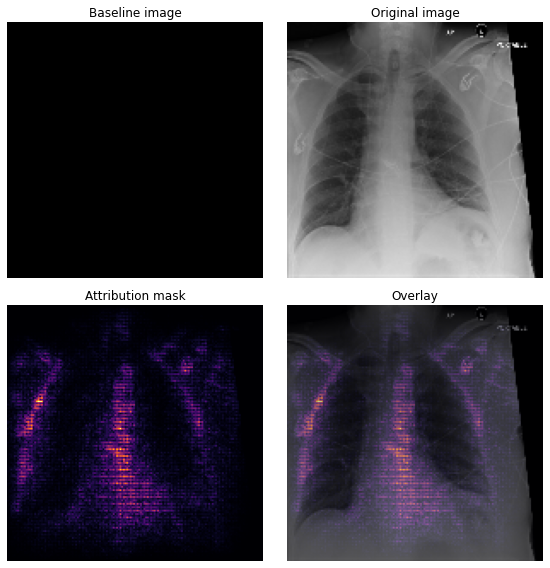

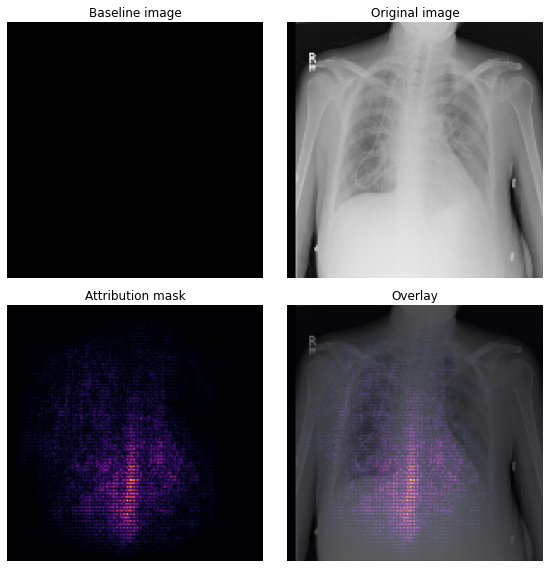

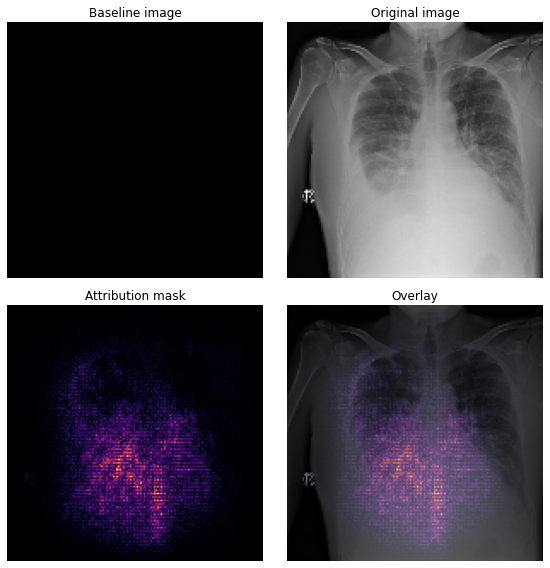

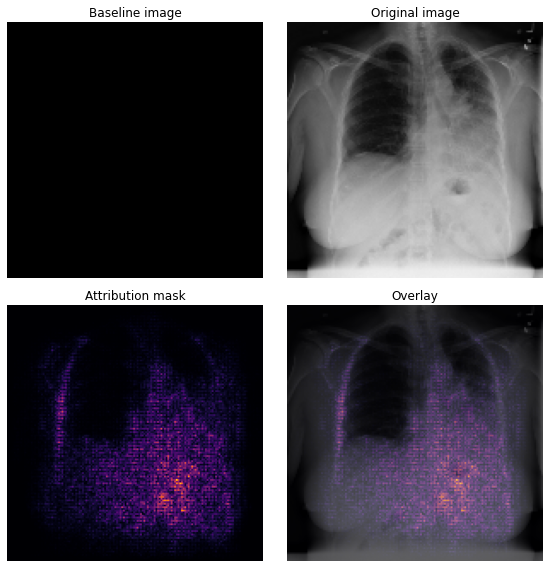

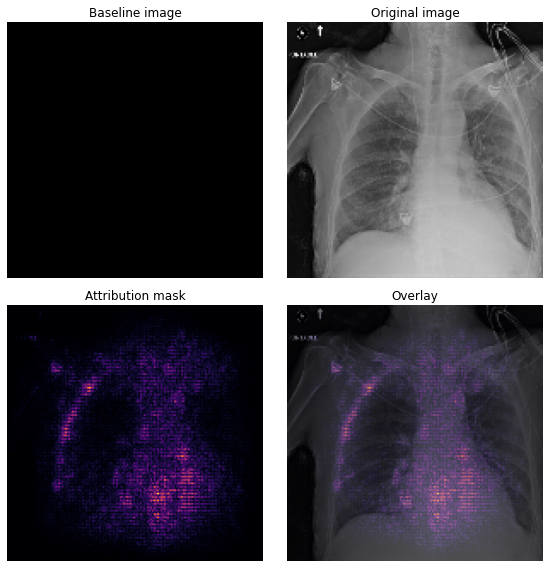

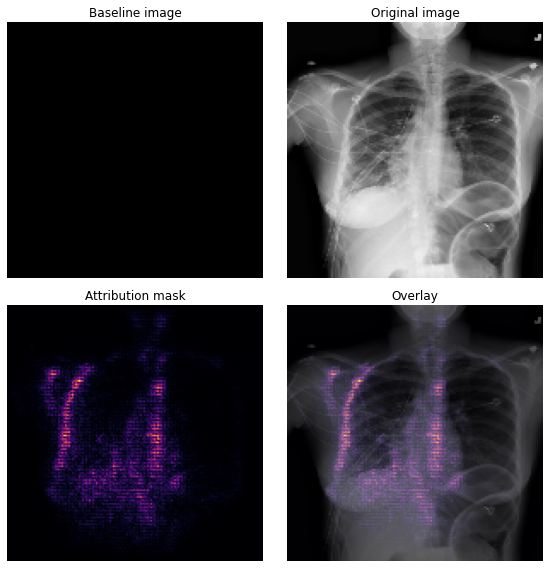

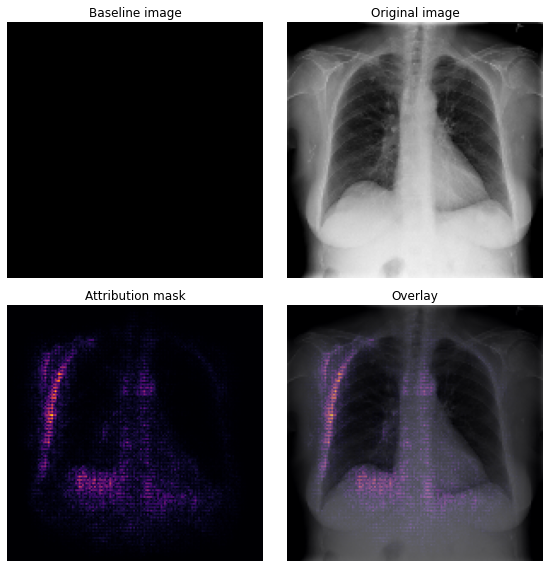

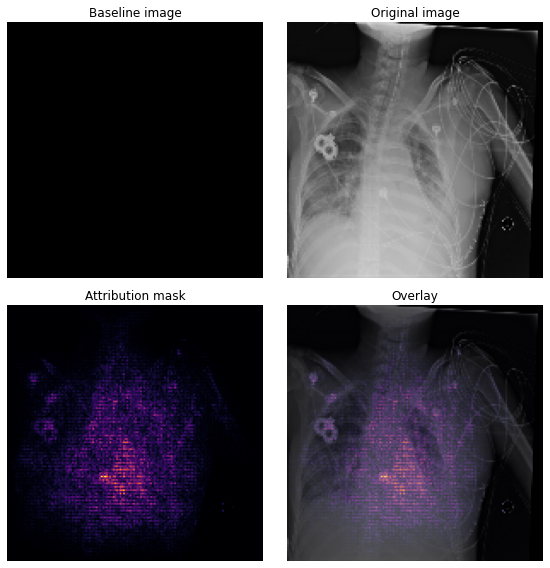

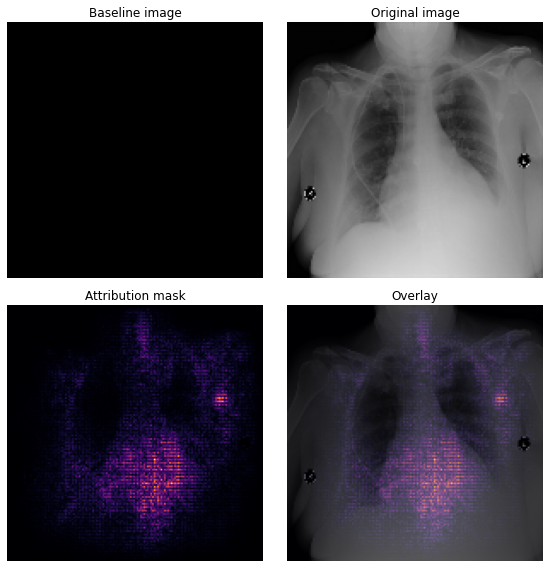

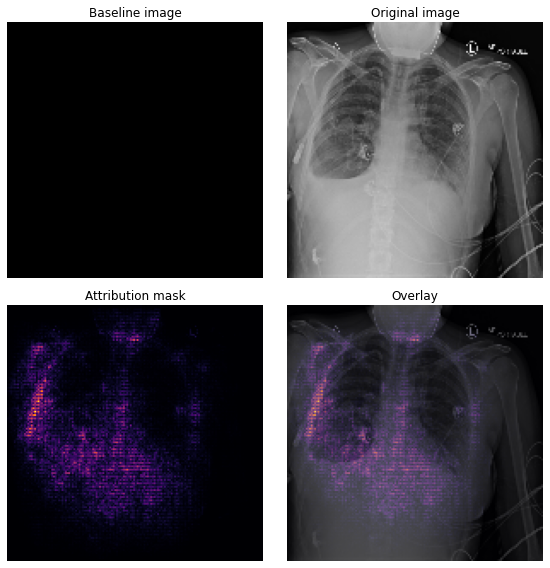

In [20]:
baseline = tf.zeros(shape=(150,150,3))
for num in Example:
    _ = plot_img_attributions(image=val_image_data[num],baseline=baseline,target_class_idx=0, m_steps=2400,
                              cmap=plt.cm.inferno, overlay_alpha=0.4)